Table of Contents

* <a href='#motivation'>Motivation</a>

* <a href='#constructor'>Constructing a dataset</a>

* <a href='#attributes'>Attributes</a>

* <a href='#access'>Accessing samples</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Saving/reloading a dataset (Serialization)</a>

* <a href='#arithmetic'> Combining multiple datasets and arithmetic on useful subsets within datasets </a>

* <a href='#portability'>Portability (e.g. with sklearn)</a>

<a id='motivation'></a>

## A Python data structure to improve handling of datasets in machine learning workflows

This class is greatly suited for neuroimaging applications (or any other domain), where each sample needs to be uniquely identified with a subject ID (or something similar). 

Key-level correspondence across data, labels (1 or 2), classnames ('healthy', 'disease') and the related helps maintain data integrity and improve the provenance, in addition to enabling traceback to original sources from where the features have been originally derived.

Just to given you a concrete examples, let's look at how an ML dataset is handled traditionally.

You have a matrix X of size n x p, with n samples and p features, and a vector y containing the target values (or class labels or class identifiers). This X and y serves as training (and test set) for a classifier like SVM to fit the data X to match y as accurately as possible.

Let's get a little more concrete:

In [1]:
import sys, os
import numpy as np
import matplotlib
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

n = 10 # number of samples
p = 3  # number of features

X = np.random.random([n, p]) # random data for illustration
y = [1]*5 + [2]*5            # random labels ...

np.set_printoptions(precision=2) # save some screen space
print('X : \n{}'.format(X))
print('y : \n{}'.format(y))

Using matplotlib backend: TkAgg
X : 
[[ 0.73  0.85  0.3 ]
 [ 0.63  0.09  0.87]
 [ 0.14  0.71  0.19]
 [ 0.25  0.33  0.08]
 [ 0.8   0.85  0.99]
 [ 0.78  0.76  0.47]
 [ 0.25  0.54  0.18]
 [ 0.57  0.98  0.36]
 [ 0.1   0.1   0.74]
 [ 0.16  0.76  0.53]]
y : 
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


Almost all the machine learning toolboxes take their input in this form: X and y, regardless of the original source that produced these features in the first place.

This is all fine if all you ever wanted to do is to extract some features, do some machine learning and dispose these features away! 

** But this is almost never the case!**

Because it doesn't simply end there.

At a minimum, I often need to know 
 * which samples are misclassified - meaning you need to know what the identifiers are and not simply their row indices in X?
 * what are the characteristics of those samples?
 * what classes do they belong to?


And all this info needs to be obtained
 * without having to write lots of code connecting few non-obvious links to disparate sources of data (numerical features X, and sample identifiers in a CSV file) to find the relevant info
 * without having to track down who or which method originally produced these features
 * how the previous personnel or grad student organized the whole dataset, if you haven't generated the features yourself from scratch

And if you are like me, you would be thinking about how would you organize your workflow such that the aforementioned tasks can be accomplished with ease.
 
This data structure attempts to accomplish that with ease. By always organizing the extracted features keyed-in into a dictionary with their *sample id*, and other important info such as *target values* and other identified info. This, by definition, preserves the integrity of the data (inability to incorrectly label samples etc).

No, this data structure doesn't offer the full [provenance tracking](http://rrcns.readthedocs.io/en/latest/provenance_tracking.html), which is quite a challenging problem. But it tries make your life a little easier in your ML workflows.

An example application is shown below, touching upon the following topics:

* <a href='#motivation'>Motivation</a>

* <a href='#constructor'>Constructing a dataset</a>

* <a href='#attributes'>Attributes</a>

* <a href='#access'>Accessing samples</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Saving/reloading a dataset (Serialization)</a>

* <a href='#arithmetic'> Combining multiple datasets and arithmetic on useful subsets within datasets </a>

* <a href='#portability'>Portability (e.g. with sklearn)</a>

Improting the necessary modules and our fancy class definition:

In [2]:
from pyradigm import MLDataset

We can now instantiate it and give it a description:

In [3]:
dataset = MLDataset()
dataset.description = 'ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.'

In [4]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
Empty dataset.

You can see the dataset some description attached to it, however we know it is empty. This can be verified in a boolean context as shown below:

In [5]:
bool(dataset)

False

Let's add samples to this dataset which is when this dataset implementation becomes really handy. Before we do that, we will define some convenience routines defined to just illustrate a simple yet common use of this dataset.

In [6]:
def read_thickness(path):
    """Dummy function to minic a data reader."""

    # in your actural routine, this might be:
    #   pysurfer.read_thickness(path).values()
    return np.random.random(2)


def get_features(work_dir, subj_id):
    """Returns the whole brain cortical thickness for a given subject ID."""

    # extension to identify the data file; this could be .curv, anything else you choose
    ext_thickness = '.thickness'

    thickness = dict()
    for hemi in ['lh', 'rh']:
        path_thickness = os.path.join(work_dir, subj_id, hemi + ext_thickness)
        thickness[hemi] = read_thickness(path_thickness)

    # concatenating them to build a whole brain feature set
    thickness_wb = np.concatenate([thickness['lh'], thickness['rh']])

    return thickness_wb

So now we have IO routines to read the data for us. Let's define where the data will come from:

In [7]:
work_dir = '/project/ADNI/FreesurferThickness_v4p3'
class_set = ['Cntrl', 'Alzmr', 'MCI']
class_sizes = [15, 12, 18]

This would obviously change for your applications, but this has sufficient properties to illustrate the point.

Let's look at what methods this dataset offers us:

In [8]:
dir(dataset)

['add_classes',
 'add_sample',
 'class_set',
 'class_sizes',
 'classes',
 'data',
 'data_and_labels',
 'del_sample',
 'description',
 'extend',
 'feature_names',
 'get_class',
 'get_feature_subset',
 'get_subset',
 'glance',
 'keys',
 'num_classes',
 'num_features',
 'num_samples',
 'random_subset',
 'random_subset_ids',
 'random_subset_ids_by_count',
 'sample_ids',
 'sample_ids_in_class',
 'save',
 'summarize_classes',
 'train_test_split_ids',
 'transform']

That's a lot of methods of convenience to organize and retrieve dataset. 

So let's go through them by their usage sections.

<a id='constructor'></a>

## Constructor

You can see there few methods such as `add_sample`, `get_subset` etc: important method being `add_sample`, which is key to constructing this dataset. Let's go ahead and some samples:

To contruct a dataset, one typically starts with a list of subject IDs to be added - we create few random lists, each to be considered as a separate class:

In [9]:
import random
from datetime import datetime
random.seed(datetime.now())

def read_target_list(class_name, class_size):
    "Generates a random target list. In reality, you would do something like the commented code below."
    target_list = list()
    for idx in range(class_size):
        target_list.append('{}{:04d}'.format(class_name[0],np.random.randint(1000)))
        
    return target_list


Now we go through each of the above classes, and add each sample that class to the dataset.

In [10]:
for class_index, class_id in enumerate(class_set):
    print('Working on class {:>5}'.format(class_id))

    target_list = read_target_list(class_id,class_sizes[class_index])
    for subj_id in target_list:
        print('\t reading subject {:>15}'.format(subj_id))
        thickness_wb = get_features(work_dir, subj_id)

        # adding the sample to the dataset
        dataset.add_sample(subj_id, thickness_wb, class_index, class_id)

Working on class Cntrl
	 reading subject           C0562
	 reading subject           C0408
	 reading subject           C0760
	 reading subject           C0170
	 reading subject           C0241
	 reading subject           C0980
	 reading subject           C0822
	 reading subject           C0565
	 reading subject           C0949
	 reading subject           C0041
	 reading subject           C0372
	 reading subject           C0141
	 reading subject           C0492
	 reading subject           C0064
	 reading subject           C0557
Working on class Alzmr
	 reading subject           A0034
	 reading subject           A0768
	 reading subject           A0240
	 reading subject           A0042
	 reading subject           A0141
	 reading subject           A0888
	 reading subject           A0032
	 reading subject           A0596
	 reading subject           A0969
	 reading subject           A0215
	 reading subject           A0074
	 reading subject           A0229
Working on class   MCI
	 reading sub

**Nice. Isn't it?**

So what's nice about this, you say? *The simple fact that you are constructing a dataset as you read the data* in its most elemental form (in the units of the dataset such as the subject ID in our neuroimaging application). You're done as soon as you're done reading the features from disk.

What's more - you can inspect the dataset in an intuitive manner, as shown below:

In [11]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples, 3 classes, 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.
Class   MCI : 18 samples.

Even better, right? No more coding of several commands to get the complete and concise sense of the dataset.

<a id='attributes'></a>

## Convenient attributes

If you would like, you can always get more specific information, such as:

In [12]:
dataset.num_samples

45

In [13]:
dataset.num_features

4

In [14]:
dataset.class_set

['MCI', 'Cntrl', 'Alzmr']

In [15]:
dataset.class_sizes

Counter({'Alzmr': 12, 'Cntrl': 15, 'MCI': 18})

In [16]:
dataset.class_sizes['Cntrl']

15

If you'd like to take a look data inside for few subjects - shall we call it a glance?

In [17]:
dataset.glance()

{'C0170': array([ 0.37,  0.78,  0.5 ,  0.79]),
 'C0241': array([ 0.11,  0.18,  0.58,  0.36]),
 'C0408': array([ 0.49,  0.38,  0.05,  0.82]),
 'C0562': array([ 0.64,  0.59,  0.01,  0.8 ]),
 'C0760': array([ 0.12,  0.51,  0.95,  0.23])}

We can control the number of items to glance, by passing a number to dataset.glance() method:

In [18]:
dataset.glance(2)

{'C0408': array([ 0.49,  0.38,  0.05,  0.82]),
 'C0562': array([ 0.64,  0.59,  0.01,  0.8 ])}

Or you may be wondering what are the subject IDs in the dataset.. here they are:

In [19]:
dataset.sample_ids

['C0562',
 'C0408',
 'C0760',
 'C0170',
 'C0241',
 'C0980',
 'C0822',
 'C0565',
 'C0949',
 'C0041',
 'C0372',
 'C0141',
 'C0492',
 'C0064',
 'C0557',
 'A0034',
 'A0768',
 'A0240',
 'A0042',
 'A0141',
 'A0888',
 'A0032',
 'A0596',
 'A0969',
 'A0215',
 'A0074',
 'A0229',
 'M0760',
 'M0434',
 'M0033',
 'M0942',
 'M0034',
 'M0868',
 'M0595',
 'M0476',
 'M0770',
 'M0577',
 'M0638',
 'M0421',
 'M0006',
 'M0552',
 'M0040',
 'M0165',
 'M0256',
 'M0127']

<a id='access'></a>

## Accessing samples

Thanks to elegant implementation, data for a given sample 'M0299' can simply be obtained by:

In [21]:
dataset['M0040']

array([ 0.27,  0.52,  0.61,  0.49])

Like a Python dict, it raises an error if the key is not in the dataset:

In [22]:
dataset['dlfjdjf']

KeyError: 'dlfjdjf not found in dataset.'

A more graceful handling would be to use `dataset.get` to control what value to be returned in case the requested id is not found in the dataset.

In [23]:
dataset.get('dkfjd', np.nan)

nan

<a id='iteration'></a>

## Iteration

Thanks to builtin iteration, we can easily iterate over all the samples:

In [24]:
for sample, features in dataset:
    print("{} : {:>10} : {}".format(sample, dataset.classes[sample], features))

C0562 :      Cntrl : [ 0.64  0.59  0.01  0.8 ]
C0408 :      Cntrl : [ 0.49  0.38  0.05  0.82]
C0760 :      Cntrl : [ 0.12  0.51  0.95  0.23]
C0170 :      Cntrl : [ 0.37  0.78  0.5   0.79]
C0241 :      Cntrl : [ 0.11  0.18  0.58  0.36]
C0980 :      Cntrl : [ 0.1   0.52  0.79  0.68]
C0822 :      Cntrl : [ 0.44  0.97  0.06  0.99]
C0565 :      Cntrl : [ 0.89  0.5   0.89  0.48]
C0949 :      Cntrl : [ 0.84  0.84  0.51  0.12]
C0041 :      Cntrl : [ 0.07  0.19  0.68  0.81]
C0372 :      Cntrl : [ 0.7   0.05  0.67  0.39]
C0141 :      Cntrl : [ 0.46  0.18  0.69  0.17]
C0492 :      Cntrl : [ 0.82  0.77  0.07  0.69]
C0064 :      Cntrl : [ 0.24  0.54  0.36  0.37]
C0557 :      Cntrl : [ 0.59  0.86  0.1   0.42]
A0034 :      Alzmr : [ 0.35  0.96  0.41  0.93]
A0768 :      Alzmr : [ 0.65  0.37  0.7   0.24]
A0240 :      Alzmr : [ 0.87  0.78  0.1   0.28]
A0042 :      Alzmr : [ 0.12  0.3   0.35  0.7 ]
A0141 :      Alzmr : [ 0.85  0.28  0.06  0.74]
A0888 :      Alzmr : [ 0.85  0.78  0.93  0.7 ]
A0032 :      

Did you see that? *It's so intuitive and natural!* Such a clean traversal of dataset.

Thanks to the choice of the OrderedDict() to represent the data, classes and labels underneath, the order of sample addition is retained. Hence the correspondence across samples in the dataset not only key-wise (by the sample id), but also index-wise.

<a id='transform'></a>

## Subject-wise transform

Quite often, we are interested in computing some statistics on data for a given subject (such as mean, or ROI-wise median). Typically this requires a loop, with some computation and organizing it in a new dataset! A simple routine pattern of usage, but can't avoided if you are still fiddling with representing your dataset in medieval matrices! :).

If you organized your dataset in a `pyradigm`, such computation is trivial, thanks to builtin implementation of `transform` method. The mean value for each subject can be computed and organized in a new dataset, with an intuitive and single line:

In [25]:
mean_data = dataset.transform(np.mean)
mean_data.description = 'mean values per subject'
mean_data

mean values per subject
45 samples, 3 classes, 1 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.
Class   MCI : 18 samples.

As the transform accepts an arbitrary callable, we could do many more sophisticated things, such as access the subset of features e.g. cortical thickness for a particular region of interest (say posterior cingulate gyrus).

In [26]:
# let's make a toy function to return the indices for the ROI
def get_ROI_indices(x): return x[:3] 

Using this "mask" function, we can easily obtain features for an ROI

In [27]:
pcg = dataset.transform(get_ROI_indices)

We can verify that the new dataset does indeed have only 3 features, for the same subjects/classes:

In [28]:
pcg

None
ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples, 3 classes, 3 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.
Class   MCI : 18 samples.

In [29]:
pcg.num_features

3

Let's make a bar plot with the just computed numbers:

In [30]:
data, lbl, keys = pcg.data_and_labels()

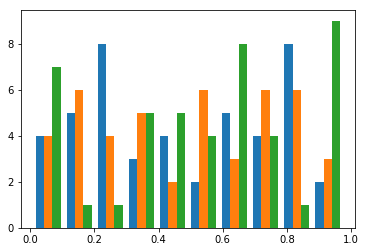

In [31]:
n, bins, patches = plt.hist(data)

Remember as the original source of data was random, this has no units, property or meaning!

<a id='subsetselection'></a>

## Subset selection

In addition to the structured way of obtaining the various properties of this dataset, this implementation really will come in handy when you have to slice and dice the dataset (with large number of classes and features) into smaller subsets (e.g. for binary classification). Let's see how we can retrieve the data for a single class:

In [32]:
ctrl = dataset.get_class('Cntrl')

That's it, obtaining the data for a given class is a simple call away.

Now let's see what it looks like:

In [33]:
ctrl


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
15 samples, 1 classes, 4 features.
Class Cntrl : 15 samples.

Even with updated description automatically, to indicate its history. Let's see some data from controls:

In [34]:
ctrl.glance(2)

{'C0408': array([ 0.49,  0.38,  0.05,  0.82]),
 'C0562': array([ 0.64,  0.59,  0.01,  0.8 ])}

We can also query a random subset of samples for manual inspection or cross-validation purposes. For example:

In [35]:
random_subset = dataset.random_subset(perc_in_class=0.3)
random_subset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
12 samples, 3 classes, 4 features.
Class Cntrl : 4 samples.
Class Alzmr : 3 samples.
Class   MCI : 5 samples.

You can see which samples were selected:

In [36]:
random_subset.sample_ids

['C0562',
 'C0565',
 'C0372',
 'C0492',
 'A0240',
 'A0032',
 'A0229',
 'M0034',
 'M0770',
 'M0552',
 'M0165',
 'M0127']

You can verify that it is indeed random by issuing another call:

In [37]:
# supplying a new seed everytime to ensure randomization
from datetime import datetime
dataset.random_subset(perc_in_class=0.3).sample_ids

['C0562',
 'C0822',
 'C0949',
 'C0141',
 'A0034',
 'A0141',
 'A0032',
 'M0434',
 'M0942',
 'M0868',
 'M0421',
 'M0552']

#### Let's see how we can retrieve specific samples by their IDs (for which there are many use cases):

In [38]:
data = dataset.get_subset(dataset.sample_ids[1:20])
data


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
19 samples, 2 classes, 4 features.
Class Cntrl : 14 samples.
Class Alzmr : 5 samples.

So as simple as that.

# Cross-validation

If you would like to develop a variant of cross-validation, and need to obtain a random split of the dataset to obtain training and test sets, it is as simple as: 

In [39]:
train_set, test_set = dataset.train_test_split_ids( train_perc = 0.5)

This method returns two sets of sample ids corresponding to training set (which 50% of samples from all classes in the dataset) and the rest in test_set. Let's see what they have:

In [40]:
train_set, test_set

(['C0760',
  'C0822',
  'C0565',
  'C0170',
  'C0562',
  'C0141',
  'C0041',
  'A0768',
  'A0888',
  'A0032',
  'A0969',
  'A0141',
  'A0034',
  'M0434',
  'M0421',
  'M0577',
  'M0256',
  'M0127',
  'M0033',
  'M0760',
  'M0476',
  'M0165'],
 ['M0040',
  'A0240',
  'C0241',
  'C0492',
  'A0074',
  'A0042',
  'M0942',
  'M0595',
  'M0006',
  'C0372',
  'C0064',
  'C0557',
  'M0552',
  'M0034',
  'C0408',
  'C0980',
  'A0229',
  'C0949',
  'A0596',
  'M0770',
  'A0215',
  'M0868',
  'M0638'])

We can also get a train/test split by specifying an exact number of subjects we would like from each class (e.g. when you would like to avoid class imbalance in the training set):

In [41]:
train_set, test_set = dataset.train_test_split_ids( count_per_class = 3)

Let's see what the training set contains - we expect 3*3 =9 subjects :

In [42]:
train_set

['C0557',
 'C0041',
 'C0949',
 'A0768',
 'A0888',
 'A0229',
 'M0165',
 'M0476',
 'M0040']

We can indeed verify that is the case, by creating a new smaller dataset from that list of ids and getting a summary:

In [43]:
training_dataset = dataset.get_subset(train_set)
training_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
9 samples, 3 classes, 4 features.
Class Cntrl : 3 samples.
Class Alzmr : 3 samples.
Class   MCI : 3 samples.

Another programmatic way to look into different classes is this:

In [44]:
class_set, label_set, class_sizes = training_dataset.summarize_classes()
class_set, label_set, class_sizes

(['MCI', 'Cntrl', 'Alzmr'], [2, 0, 1], array([ 3.,  3.,  3.]))

which returns all the classes that you could iterative over.

Using these two lists, we can easily obtain subset datasets, as illustrated below.

In [45]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
45 samples, 3 classes, 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.
Class   MCI : 18 samples.

In [46]:
binary_dataset = dataset.get_class(['Cntrl','Alzmr'])
binary_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples, 2 classes, 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

How about selecting a subset of features from all samples?

In [47]:
binary_dataset.get_feature_subset(range(2))

Subset features derived from: 
 
 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples, 2 classes, 2 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

**Great.** Isn't it? You can also see the two-time-point history (initial subset in classes, followed by a subset in features).

<a id='serialization'></a>

## Serialization

Once you have this dataset, you can save and load these trivially using your favourite serialization module. Let's do some pickling:

In [48]:
out_file = os.path.join(work_dir,'binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.MLDataset.pkl')
binary_dataset.save(out_file)

That's it - it is saved.

Let's reload it from disk and make sure we can indeed retrieve it:

In [49]:
reloaded = MLDataset(filepath=out_file) # another form of the constructor!

In [50]:
reloaded


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
27 samples, 2 classes, 4 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.

We can check to see they are indeed one and the same:

In [51]:
binary_dataset == reloaded

True

<a id='arithmetic'></a>

## Dataset Arithmetic

You might wonder how can you combine two different types of features ( thickness and shape ) from the dataset. Piece of cake, see below ...

To concatenat two datasets, first we make a second dataset:

In [52]:
dataset_two = MLDataset(in_dataset=dataset) # yet another constructor: in its copy form!

How can you check if they are "functionally identical"? As in same keys, same data and classes for each key... Easy:

In [53]:
dataset_two == dataset

True

Now let's try the arithmetic:

In [54]:
combined = dataset + dataset_two

Identical keys found. Trying to horizontally concatenate features for each sample.


Great. The add method recognized the identical set of keys and performed a horiz cat, as can be noticed by the twice the number of features in the combined dataset:

In [55]:
combined

45 samples, 3 classes, 8 features.
Class Cntrl : 15 samples.
Class Alzmr : 12 samples.
Class   MCI : 18 samples.

We can also do some removal in similar fashion:

In [56]:
smaller = combined - dataset

C0562 removed.
C0408 removed.
C0760 removed.
C0170 removed.
C0241 removed.
C0980 removed.
C0822 removed.
C0565 removed.
C0949 removed.
C0041 removed.
C0372 removed.
C0141 removed.
C0492 removed.
C0064 removed.
C0557 removed.
A0034 removed.
A0768 removed.
A0240 removed.
A0042 removed.
A0141 removed.
A0888 removed.
A0032 removed.
A0596 removed.
A0969 removed.
A0215 removed.
A0074 removed.
A0229 removed.
M0760 removed.
M0434 removed.
M0033 removed.
M0942 removed.
M0034 removed.
M0868 removed.
M0595 removed.
M0476 removed.
M0770 removed.
M0577 removed.
M0638 removed.
M0421 removed.
M0006 removed.
M0552 removed.
M0040 removed.
M0165 removed.
M0256 removed.
M0127 removed.


/Users/Reddy/dev/pyradigm/pyradigm/pyradigm.py:1169: UserWarning: Requested removal of all the samples - output dataset would be empty.
  warnings.warn('Requested removal of all the samples - output dataset would be empty.')


Data structure is even producing a warning to let you know the resulting output would be empty! We can verify that:

In [57]:
bool(smaller)

False

<a id='portability'></a>

## Portability

This is all well and good. How does it interact with other packages out there, you might ask? It is as simple as you can imagine:

In [58]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

In [59]:
data_matrix, target, sample_ids = binary_dataset.data_and_labels()
clf.fit(data_matrix, target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

There you have it, a simple example to show you the utility and convenience of this dataset.

### Thanks for checking it out. 

### I would appreciate if you could give me feedback on improving or sharpening it further.